In [ ]:
import bz2
import sys
import os
MODEL_CAPACITIES = MODEL_CAPACITIES = ['tiny', 'small', 'medium', 'large', 'full']

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

In [ ]:

#
# Download crepe models from reference repo
#
def download():
    weight_files = ['model-{}.h5'.format(cap) for cap in MODEL_CAPACITIES]
    base_url = 'https://github.com/marl/crepe/raw/models/'

    if len(sys.argv) > 1 and sys.argv[1] == 'sdist':
        # exclude the weight files in sdist
        weight_files = []
    else:
        os.makedirs('temp_weights', exist_ok=True)
        # in all other cases, decompress the weights file if necessary
        for weight_file in weight_files:
            weight_path = os.path.join('temp_weights', weight_file)
            if not os.path.isfile(weight_path):
                compressed_file = weight_file + '.bz2'
                compressed_path = os.path.join('temp_weights', compressed_file)
                if not os.path.isfile(compressed_file):
                    print('Downloading weight file {} ...'.format(compressed_file))
                    urlretrieve(base_url + compressed_file, compressed_path)
                print('Decompressing ...')
                with bz2.BZ2File(compressed_path, 'rb') as source:
                    with open(weight_path, 'wb') as target:
                        target.write(source.read())
                print('Decompression complete')

In [3]:
download()

In [4]:
from crepe.core import build_and_load_model

In [5]:
m = build_and_load_model('tiny')

In [6]:
ls = m.get_weights()

In [7]:
len(ls)

38

- Tensorflow weights
  - conv : weight (I, O, Height, Width) , bias 
  - bn : gamma beta moving_mean, moving_var
  
- Pytorch weights
  - conv : weight (O, I, Width, Height), bias
  - bn : 갖다 붙이면 될듯

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class CREPE(nn.Module):
    
    def __init__(self, capacity: int, sr: int = 16000, step_size: int = 10):
        super().__init__()
        layers = [1, 2, 3, 4, 5, 6]
        self.filters = [n * capacity for n in [32, 4, 4, 4, 8, 16]]
        self.strides = [4, 1, 1, 1, 1, 1]
        self.widths = [512, 64, 64, 64, 64, 64]
        
        self.hop_length = int(sr * step_size / 1000)
        self.window = 1024
        self.last_mult = 4
        
        modules = []
        in_channel = 1
        for l, f, w, s in zip(layers, self.filters, self.widths, self.strides):
            block = nn.Sequential(
                nn.Conv1d(in_channel, f, w, stride=s),
                nn.ReLU(),
                nn.BatchNorm1d(f),
                nn.MaxPool1d(2),
                nn.Dropout(0.25)
            )
            in_channel = f
            modules.append(block)
            
        self.net = nn.ModuleList(modules)
            
        self.out_linear = nn.Sequential(
            nn.Linear(self.filters[-1] * self.last_mult, 360),
            nn.Sigmoid()
        )
        

        
    def forward(self, x):
        
        _, T = x.size()
        n_frames = 1 + int((T - self.window) / self.hop_length)
        temp = [x[:, idx * self.hop_length: idx * self.hop_length + self.window] for idx in range(n_frames)]
        x = torch.cat(temp, axis=0).unsqueeze(1)
        x = (x - x.mean(axis=2, keepdim=True)) / x.std(axis=2, keepdim=True)
        
        for block, w, s in zip(self.net, self.widths, self.strides):
            x_len = x.size(-1)
            head = ((x_len / s - 1) * s + w - x_len)
            side, remain = int(head) // 2, int(head % 2)
            
            x = F.pad(x, (side, side + remain))
            x = block(x)

        return self.out_linear(x.view(-1, self.filters[-1] * self.last_mult))

In [10]:
crepe = CREPE(4)

In [11]:
crepe.out_linear[0].weight.size()

torch.Size([360, 256])

In [12]:
weights = [torch.FloatTensor(w) for w in m.get_weights()]
idx = 0

for block_idx in range(6):
    # conv
    crepe.net[block_idx][0].weight.data = weights[idx].permute(3, 2, 1, 0)[..., 0, :]
    crepe.net[block_idx][0].bias.data = weights[idx + 1]
    # bn
    crepe.net[block_idx][2].weight.data = weights[idx + 3]
    crepe.net[block_idx][2].bias.data = weights[idx + 2]
    
    idx += 6
    
crepe.out_linear[0].weight.data = weights[-2].transpose(0, 1)
crepe.out_linear[0].bias.data = weights[-1]

In [13]:
m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
input-reshape (Reshape)      (None, 1024, 1, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 1, 128)       65664     
_________________________________________________________________
conv1-BN (BatchNormalization (None, 256, 1, 128)       512       
_________________________________________________________________
conv1-maxpool (MaxPooling2D) (None, 128, 1, 128)       0         
_________________________________________________________________
conv1-dropout (Dropout)      (None, 128, 1, 128)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 1, 16)        131088

In [14]:
for l in m.get_weights():
    print(l.shape)

(512, 1, 1, 128)
(128,)
(128,)
(128,)
(128,)
(128,)
(64, 1, 128, 16)
(16,)
(16,)
(16,)
(16,)
(16,)
(64, 1, 16, 16)
(16,)
(16,)
(16,)
(16,)
(16,)
(64, 1, 16, 16)
(16,)
(16,)
(16,)
(16,)
(16,)
(64, 1, 16, 32)
(32,)
(32,)
(32,)
(32,)
(32,)
(64, 1, 32, 64)
(64,)
(64,)
(64,)
(64,)
(64,)
(256, 360)
(360,)


### Test

In [15]:
import librosa
from IPython.display import Audio

In [16]:
# test
wav, sr = librosa.load('/home/appleholic/workspace/data/customs/uinna/audio_processed/chunks/20141106._102.wav', sr=16000)

In [17]:
wav_tensor = torch.FloatTensor(wav)

%time out = crepe(wav_tensor.unsqueeze(0))

CPU times: user 1.08 s, sys: 144 ms, total: 1.23 s
Wall time: 167 ms


In [18]:
out.size()

torch.Size([322, 360])

In [19]:
from crepe.core import to_viterbi_cents, to_local_average_cents, predict

In [20]:
%time cents = to_viterbi_cents(out.detach().cpu().numpy())

CPU times: user 65.3 ms, sys: 326 µs, total: 65.6 ms
Wall time: 64.7 ms


In [21]:
cents.shape

(322,)

In [22]:
frequency = 10 * 2 ** (cents / 1200)

In [23]:
frequency

array([227.93706476, 230.87409355, 237.66410309, 229.09789592,
       209.13848193, 193.0455714 , 181.07851314, 186.51361239,
       188.382665  , 189.91173067, 197.01894285, 201.93501927,
       208.15421956, 215.46298687, 229.50503461, 230.78957229,
       239.77394392, 231.07350243, 227.4431684 , 223.44340505,
       216.90600235, 211.55067897, 210.66969168, 211.39905333,
       207.99738998, 209.67236174, 216.3394306 , 223.75107105,
       221.56844935, 224.16596343, 209.85463298, 196.6926963 ,
       183.57514229, 190.30443921, 205.74472036, 209.47398475,
       215.57954486, 217.07655695, 218.92491232, 227.77321468,
       231.87786486, 247.52144943, 237.98517387, 239.06224478,
       235.66435222, 241.79038641, 240.91248623, 249.90213314,
       266.78505201, 290.53312169, 282.57655804, 259.81923583,
       254.61237318, 247.63098018, 219.82174463, 200.30439045,
       179.92282869, 187.47813003, 197.53591844, 186.55928421,
       181.30725359, 184.84168275, 191.71254743, 201.25

In [24]:
Audio(wav, rate=sr)

In [32]:
p = predict(wav, sr, model_capacity='full')

329/329 [==============================] - 1s 2ms/sample


In [33]:
import matplotlib.pyplot as plt

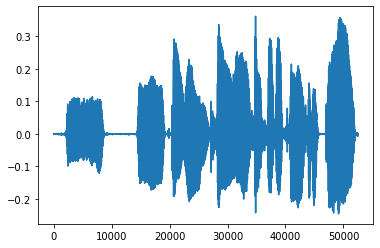

In [34]:
plt.plot(wav)

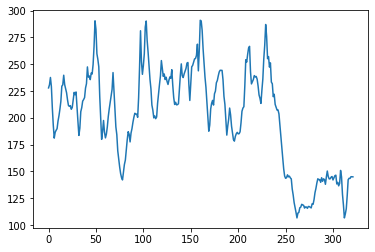

In [35]:
plt.plot(frequency)

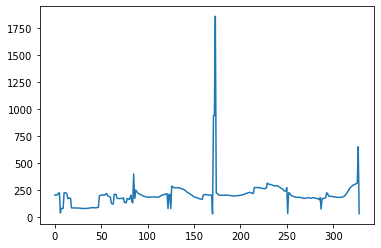

In [36]:
plt.plot(p[1])